In [1]:
#Write a Three Body Integrator without using any additional math library. Place two bodies of the same mass on a stationary circular orbit around each other, and take a 3rd body with a negligible mass. Initial coordinates and velovity for the third body is an input. Output the trajectory of all three bodies for 10 orbital revolutions for several initial inputs for the third body, and plot it on xy and xz. Send the code, ignore the effect of the 3rd body on the two bodies. Anticipate numerical errors in the code for the 3rd body trajectory.
import numpy as np
import matplotlib.pyplot as plt
from astropy.constants import M_sun
from scipy.constants import G 

In [2]:
#Initial Condition
"""
The following program outputs the pathway of a number of massless particle at input distances and velocities as they pulled by the gravitational force of 2 massive orbiting bodies in a perfect circular orbit.
The 2 massive bodies follow a perfect track, the period is calculated from the semimajor axis and there is an optional input for semimajor axis, number of revolutions and steps per revolution. 
Inputs (optional)
a | semimajor axis of binary orbit, input as a float.
Revolutions | total number of revolutions before ending program, input as a float.
StepsPerOrbit | number of discrete points to calculate next position and velocity of 3rd particle, also the number of points the massive objects will inhabit per revolution, input as a float.
Inputs (Required)
R3i | initial position in 3d space, input as an list of lists of floats (x,y,z).
V3i | initial velocity in 3d space, input as an list of list of floats (vx,vy,vz).

Outputs
R3out | an array of 3 dimensional position arrays of the 3rd negligable mass object's position at each step for each input.
x1,y1,z1,x2,y2,z2 | 6 lists containing the 1st and second massive object's position at each step.
"""
#Optional Inputs
#Semimajor axis of binary orbit
a = 149597870700*20 #20AU
#Mass of Massive Objects
M1 = M_sun.value
M2 = M1
#Number of times the binary system completes an orbital revolution
Revolutions = 10
#Number of steps per orbit
StepsPerOrbit = 10000

#First test point given a starting position and velocity of a circular orbit around M1 at a distance of a/5 as a fun example
a0 = a/5
testvel = (G*M1/a0)**0.5
testypos = a+a0

#Required Inputs
#Input values, script is capable of handling a number of input points and velocities of those points
R3i = [[0,testypos,0],[2*a,2*a,2*a],[2*a/2,2*a/2,2*a/2],[4*a,4*a,4*a],[-2*a/2,-2*a/2,-2*a/2]]
#Initial Velocity of 3rd negligable mass point, (vx,vy,vz)
V3i = [[testvel,0,0],[-10**3,-10**3,10**3],[-10**2,-10**2,-10**2],[10**2,10**2,10**2],[0,0,0]]

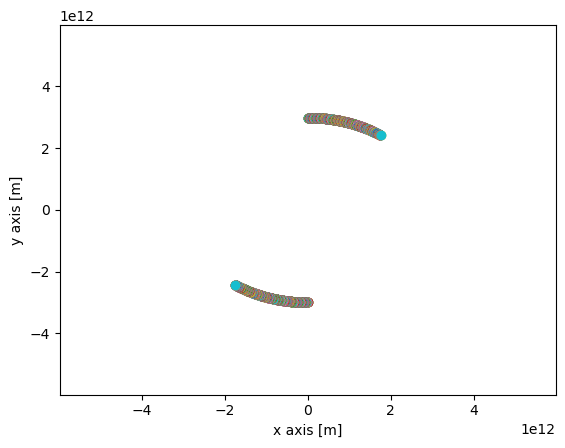

In [3]:
#For a circular orbit, r = a
r = a

#Orbital Period for 2 bodies orbiting each other
T = 2*np.pi*((a**3)/(G*(M1+M2)))**0.5

#Simplify by including steps along ideal orbit, with N divisions of N+1 points for Nrev revolutions.
N = Revolutions*StepsPerOrbit
Nrev = Revolutions
Totaltime = T*Nrev
theta = np.linspace(0,360*Nrev,N+1)
StepTime = Totaltime/(N)
dt = StepTime

#Place the objects at points along this path, again assuming the two bodies are orbiting in the xy plane around point 0,0
x1 = r*np.sin(np.radians(theta))
y1 = r*np.cos(np.radians(theta))
x2 = -r*np.sin(np.radians(theta))
y2 = -r*np.cos(np.radians(theta))


#Testtrack
fig = plt.figure()
axis = plt.axes(xlim = (-a*2,a*2), ylim = (-a*2,a*2))
plt.xlabel('x axis [m]')
plt.ylabel('y axis [m]')
plt.plot()
for i in range(1000):
    plt.scatter((x1[i],x2[i]),(y1[i],y2[i]))

In [4]:
#Now with the 2 objects positions defined, we can define gravitational acceleration from those two objects on a 3rd negligible point mass at arbitrary position. 

def getacceleration(r1,r2,r3,M1,M2):
    """Takes 3 position inputs and 2 mass inputs, outputs acceleration on the third particle due to the gravity of the other two.
    Inputs
    r1/r2 = (x,y,z) position of massive point masses in meters
    r3 = (x,y,z) position of negligible mass particle in meters
    M1/M2 = mass of massive point masses in kilograms
    Outputs
    a = (ax,ay,az) acceleration of negligible mass particle
    """
    #Gravitational equation
    d1 = ((r1[0]-r3[0])**2+(r1[1]-r3[1])**2+(r1[2]-r3[2])**2)**0.5 #distance from object 3 to mass 1
    a1 = (G*M1)/(d1**2) #acceleration from mass 1

    #acceleration multiplied by normalized distance difference vectors for the direction and magnitude for individual pieces.
    a1x = a1*((r1[0]-r3[0])/d1)
    a1y = a1*((r1[1]-r3[1])/d1)
    a1z = a1*((r1[2]-r3[2])/d1)
    
    d2 = ((r2[0]-r3[0])**2+(r2[1]-r3[1])**2+(r2[2]-r3[2])**2)**0.5 #distance from object 3 to mass 2
    a2 = G*M2/(d2**2) #acceleration from mass 2
    
    #acceleration multiplied by normalized distance difference vectors for the direction and magnitude for individual pieces.
    a2x = a2*((r2[0]-r3[0])/d2)
    a2y = a2*((r2[1]-r3[1])/d2)
    a2z = a2*((r2[2]-r3[2])/d2)
    
    
    a = (a1x+a2x,a1y+a2y,a1z+a2z)
    return(a)

#Simple prediction of next velocity, then a trapezoid method numerical integration for the position.
def getnextposition(x1,v1,dt,a1):
    #Using Forward Euler method for next velocity v_{n+1} from v_{n}
    v2 = v1+dt*a1
    #Using Newton-Cotes trapezoid method for next position x_{n+1} from x_{n}
    x2 = x1+(dt/2)*(v1+v2)
    return(x2)

In [5]:
#initialize output
R3out = np.array(([np.zeros(N+1),np.zeros(N+1),np.zeros(N+1)],)*len(R3i))
#Loop over all inputs
for j in range(len(R3i)):
    #Create arrays
    m3a = [[0,0,0]]*(N+1)
    m3aprojected = [[0,0,0]]*(N+1)
    vx3 = np.zeros(N+1)
    vy3 = np.zeros(N+1)
    vz3 = np.zeros(N+1)

    #Initial Conditions
    R3out[j][0][0] = R3i[j][0]
    R3out[j][1][0] = R3i[j][1]
    R3out[j][2][0] = R3i[j][2]
    vx3[0] = V3i[j][0]
    vy3[0] = V3i[j][1]
    vz3[0] = V3i[j][2]
    
    #Step by step predict the next position by numerically integrating with a simple prediction for the next velocity, then numerically integrate to get a better estimated velocity for the next position.
    for i in range(N):
        m3a[i] = getacceleration((x1[i],y1[i],0),(x2[i],y2[i],0),(R3out[j][0][i],R3out[j][1][i],R3out[j][2][i]),M1,M2) #acceleration at current point
        R3out[j][0][i+1] = getnextposition(R3out[j][0][i],vx3[i],dt,m3a[i][0]) #position at next point using the simple trapezoid method
        R3out[j][1][i+1] = getnextposition(R3out[j][1][i],vy3[i],dt,m3a[i][1]) 
        R3out[j][2][i+1] = getnextposition(R3out[j][2][i],vz3[i],dt,m3a[i][2])
        m3aprojected[i] = getacceleration((x1[i+1],y1[i+1],0),(x2[i+1],y2[i+1],0),(R3out[j][0][i+1],R3out[j][1][i+1],R3out[j][2][i+1]),M1,M2)
        vx3[i+1] = vx3[i]+(dt/2)*(m3a[i][0]+m3aprojected[i][0]) #velocity at next point using trapezoid rule with predicted position from FE
        vy3[i+1] = vy3[i]+(dt/2)*(m3a[i][1]+m3aprojected[i][1])
        vz3[i+1] = vz3[i]+(dt/2)*(m3a[i][2]+m3aprojected[i][2])
    


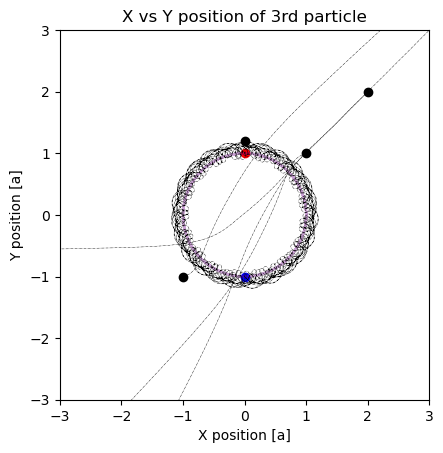

In [6]:
#XY graph, dots are starting positions
fig = plt.figure()
axis = plt.axes(xlim = (-3,3), ylim = (-3,3))
axis.set_aspect('equal')
plt.xlabel('X position [a]')
plt.ylabel('Y position [a]')
plt.title('X vs Y position of 3rd particle')
plt.plot(x1/a,y1/a, color = 'red', alpha = 0.2)
plt.scatter(x1[0]/a,y1[0]/a, color = 'red')
plt.plot(x2/a,y2/a, color = 'blue', alpha = 0.2)
plt.scatter(x2[0]/a,y2[0]/a, color = 'blue')

for k in range(len(R3i)):
    plt.scatter(R3out[k][0][0]/a,R3out[k][1][0]/a, color = 'black')
    plt.plot(R3out[k][0]/a,R3out[k][1]/a, ls = '-.', lw = '0.3', color = 'black')

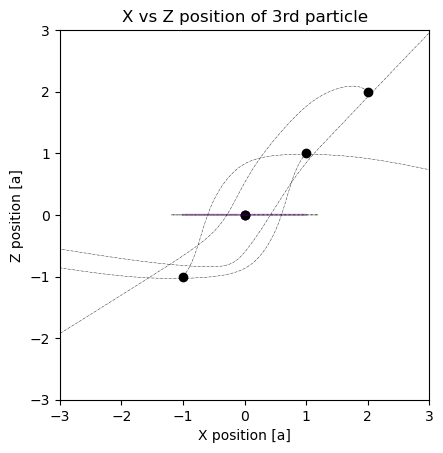

In [7]:
#XZ graphs, dots are starting positions
fig = plt.figure()
axis = plt.axes(xlim = (-3,3), ylim = (-3,3))
axis.set_aspect('equal')
plt.xlabel('X position [a]')
plt.ylabel('Z position [a]')
plt.title('X vs Z position of 3rd particle')
plt.plot(x1/a,0*x1, color = 'red', alpha = 0.2)
plt.scatter(x1[0]/a,0*x1[0]/a, color = 'red')
plt.plot(x2/a,0*x2, color = 'blue', alpha = 0.2)
plt.scatter(x2[0]/a,0*x2[0]/a, color = 'blue')
for k in range(len(R3i)):
    plt.scatter(R3out[k][0][0]/a,R3out[k][2][0]/a, color = 'black')
    plt.plot(R3out[k][0]/a,R3out[k][2]/a, ls = '-.', lw = '0.3', color = 'black')